In [12]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import t
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

In [2]:
df = pd.read_csv('Data/covid19-data-Canada.csv', parse_dates=['date'])
populations = [38, 14.7, 8.6, 5.15, 4.4, 1.18, 1.38]
df.head()

,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [3]:
run -i Skeleton.py

Below we take real data for removed in Ontario, Canada
(The real data covers the period between July 17, 2020 and January 8, 2021)

In [4]:
places = {0 : 'Canada', 1: 'Ontario', 2: 'Quebec', 3: 'British Columbia', 4: 'Alberta', 5: 'Saskatchewan', 6: 'Manitoba'}
i = 0
place = places[i]
N = populations[i]*1e6
start, end = 144, 319     # Chosen to match dates analyzed in literature
print ((place))

Canada


In [5]:
Rem, act_ont, Susc, t_ont = Canada_init(place)

The following can be derived from the SIR model:

 $\log\left(\frac{S(t)}{S(t_s)}\right) = -\frac{R_0}{N}\cdot(R(t)-R(t_s))$     (1)

$R(t) - R(t_s) = \gamma \int_{t_s}^t I(\tau) \mathrm{d}\tau$    (2)

Errors are computed below (95% confidence interval)

In [13]:
lhs1 = np.log(Susc / Susc[0])
rhs1 = Rem

res = stats.linregress(rhs1, lhs1)
#print(res.intercept*N/Rem[0])
R_0 = -res.slope*N
print(R_0)
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(rhs1)-2)

textR_0 = str((f"{-N*res.slope:.6f} ± {N*ts*res.stderr:.6f}"))
R_0err = N*ts*res.stderr
print("R_0 = " + textR_0)

1.2262617398674136
R_0 = 1.226262 ± 0.008833


In [8]:
Infec = np.array(act_ont[start:end])
lhs2 = np.array(rhs1)
#t = np.arange(0,len(Infec))
rhs2 = integrate(Infec)
res2 = stats.linregress(rhs2, lhs2)
gamma = res2.slope
tinv2 = lambda p, df: abs(t.ppf(p/2, df))
ts2 = tinv2(0.05, len(rhs2)-2)

textgamma = str((f"{res2.slope:.6f} ± {ts2*res2.stderr:.6f}"))
gammaerrslope = ts2*res2.stderr
gammaintercept = res2.intercept

print("gamma =", textgamma)

gamma = 0.082748 ± 0.000321


In [23]:
print("gamma =", f"{gamma:.6f}", "±", f"{gammaerrslope:.6f}")
print("R_0 =", textR_0)
print("beta =", f"{gamma*R_0:.6f}", "±", f"{np.sqrt(R_0err**2+gammaerrslope**2):.6f}")

gamma = 0.082748 ± 0.000321
R_0 = 1.226262 ± 0.008833
beta = 0.101471 ± 0.008839


Genearate SIR model with computed $R_0$, $\gamma$ and $\beta$

In [10]:
I0, R0, V0 = Infec[0], Rem[0], 0
S0 = N - I0 - R0 - V0
t = np.arange(0, len(t_ont[start:end]))
# Initial conditions vector
beta = gamma*R_0
y0 = S0, I0, R0, V0
#vaccines
alpha, u = 0, 0

ret = odeint(deriv, y0, t, args=(beta, gamma))
S_model, I_model, R_model, V_model = ret.T

Below are all relevant plots

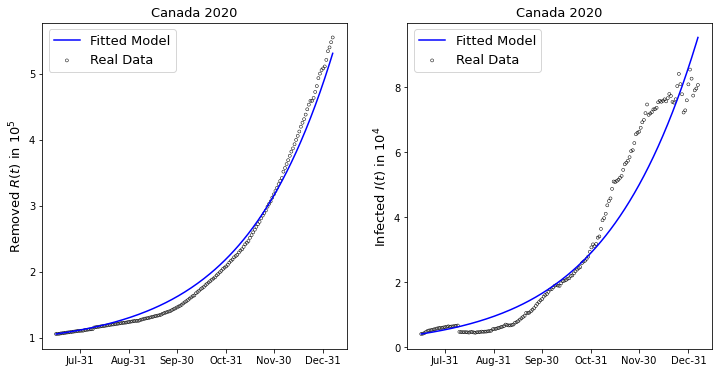

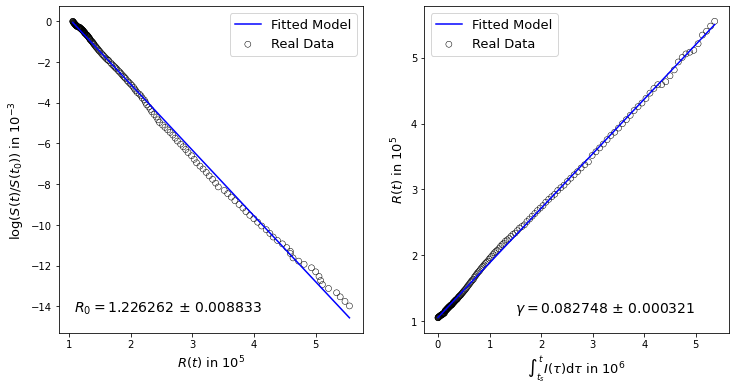

In [11]:
# Plot removed and infected

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6)) 
date_form = DateFormatter('%b-%d')

ax1.xaxis.set_major_formatter(date_form)
ax1.scatter(np.array(t_ont[start:end]),np.array(Rem)/1e5, marker='.', label = "Real Data", facecolors='none', edgecolors='k', linewidths=0.5,)
ax1.set_ylabel('Removed $R(t)$ in $10^5$', fontsize=13)
ax1.plot(t_ont[start:end], R_model/1e5, label = "Fitted Model", c = 'b')
ax1.set_title(place+" 2020", fontsize=13)


ax2.xaxis.set_major_formatter(date_form)
ax2.scatter(t_ont[start:end],np.array(act_ont[start:end])/1e4, marker='.', label = "Real Data", facecolors='none', edgecolors='k', linewidths=0.5,) 
ax2.set_ylabel('Infected $I(t)$ in $10^{4}$', fontsize=13)
ax2.set_title(place+" 2020", fontsize=13)
ax2.plot(t_ont[start:end], I_model/1e4, label = "Fitted Model", c = 'b')

ax1.legend(fontsize = 13)
ax2.legend(fontsize = 13)

plt.show()


#Plot data from which R_0 and gamma are obtained

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,6)) 
ax3.scatter(rhs1/1e5, lhs1/1e-3, facecolors='none', edgecolors='k', linewidths=0.5,label = "Real Data")
ax3.set_xlabel("$R(t)$ in $10^5$", fontsize=13)
ax3.set_ylabel("$\log(S(t)/S(t_0))$ in $10^{-3}$", fontsize=13)
ax3.plot(rhs1/1e5, (res.slope*rhs1+res.intercept)/1e-3, c = 'b', label = "Fitted Model")
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax3.text(0.05, 0.1, r"$R_0 = $" +textR_0, transform=ax3.transAxes, fontsize=14,
        verticalalignment='top')#, bbox=props)
ax3.legend(fontsize = 13)

ax4.scatter(rhs2/1e6, lhs2/1e5, facecolors='none', edgecolors='k', linewidths=0.5,label = "Real Data")
ax4.plot(rhs2/1e6, (gamma * rhs2 + gammaintercept)/1e5, c = 'b', label = "Fitted Model")
#ax4.plot(rhs2/1e6, ((gamma+gammaerrslope) * rhs2 + (gammaintercept))/1e5, c = 'r', label = "Fitted Model", linestyle='dashed') #attempt at plotting confidence interval but it's too small...




ax4.set_xlabel(r'$\int_{t_s}^t I(\tau) \mathrm{d}\tau$ in $10^6$', fontsize=13)
ax4.set_ylabel('$R(t)$ in $10^5$', fontsize=13)
ax4.text(1.5, 0.1, r"$\gamma = $" + textgamma, transform=ax3.transAxes, fontsize=14,      # insert gamma error here.
        verticalalignment='top')
ax4.legend(fontsize=13)

plt.show()